<h1 style="font-size:30px;">Gradient Descent for Optimization</h1>

In this notebook, we will use a simple example to demonstrate an algorithm called **Gradient Descent**. Gradient descent is a gradient-based optimization algorithm that is used extensively in machine learning and deep learning to minimize a loss function by iteratively adjusting the model parameters in the direction of steepest descent based on the negative gradient. Specifically, we will look at how to fit a straight line through a set of points to determine the slope of the line. To do this, we will define a loss function that quantifies the error between the data and the mathematical model we choose to represent the data, and we will use this loss function to develop an update rule that will iteratively converge to the optimal value. We will conclude the notebook with a variation on the Gradient Descent algorithm called **Mini-Batch Stochastic Gradient Descent** which is the basis for training neural networks.

**Note**: This notebook could also be coded entirely with Python and NumPy, but we will start using basic TensorFlow variables and functions to introduce the framework.

    
## Table of Contents
* [1 Create Some Data](#1-Create-Some-Data)
* [2 Define a Model for the Data](#2-Define-a-Model-for-the-Data)
* [3 Define a Loss Function](#3-Define-a-Loss-Function)
* [4 Optimization](#4-Optimization)
    * [4.1 Brute Force Search](#4.1-Brute-Force-Search)
    * [4.2 Gradient Descent](#4.2-Gradient-Descent)
    * [4.3 Stochastic Gradient Descent](#4.3-Stochastic-Gradient-Descent)
    * [4.4 Stochastic Gradient Descent with Mini-Batch](#4.4-Stochastic-Gradient-Descent-with-Mini\-Batch)
* [5 Automatic Differentiation with GradientTape](#5-Automatic-Differentiation-with-GradientTape)
    * [5.1 Using GradientTape](#5.1-Using-GradientTape)
    * [5.2 Gradient Descent with GradientTape](#5.2-Gradient-Descent-with-GradientTape)

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
plt.rcParams["figure.figsize"] = (15, 6)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
block_plot = False

## 1 Create Some Data

In [3]:
def create_data():

    # Random manual seed for consistency.
    tf.random.set_seed(42) 
    
    num_data = 30

    # Create some data that is roughly linear (but not exactly).
    x = 10 * tf.random.uniform(shape=[num_data])
    y = x + tf.random.normal(stddev= 0.3, shape=[num_data])
    
    return x, y

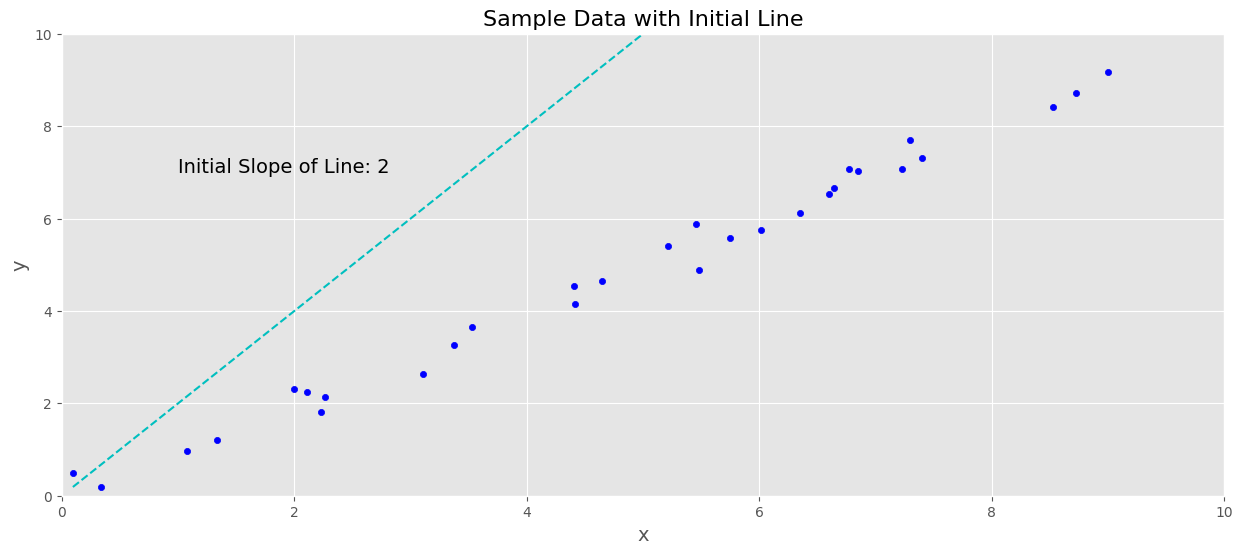

In [4]:
# Create some data.
x, y = create_data()

# Generate the data for the initial line with a slope of 2.
xmin = tf.reduce_min(x)
xmax = tf.reduce_max(x)

xplot = np.linspace(xmin, xmax, 2)
m0 = 2
yplot = m0 * xplot

# Plot the sample data and the initial guess for a line.
plt.figure
plt.scatter(x, y, color='blue', s=20)
plt.xlabel('x')
plt.ylabel('y')
plt.plot(xplot, yplot, 'c--')
plt.title('Sample Data with Initial Line')
plt.text(1, 7, 'Initial Slope of Line: ' + str(m0), fontsize=14)
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.show(block=block_plot)

## 2 Define a Model for the Data

Our model for the data is a straight line, and we will simplify the problem so that the line passes through the origin. The equation for such a line is:

$$
y = mx
$$

The model has a single unknown parameter $m$ (the slope of the line) that we wish to compute.

## 3 Define a Loss Function

Let's now define a **loss** function that quantifies the error between our model and any particular data point. For any given value of $x_i$ in our dataset, we have the corresponding value for $y_i$ as well as an estimate given by $mx_i$. So, we will have an error or a residual given by:

$$
e_i = (y_i - m x_i) 
$$

We want to find a value of $m$ that minimizes the error above. Positive or negative values of error are equally bad for us. So if we square the error, we can define a loss metric that equally measures errors in either direction (above or below the line). The line that best fits the dataset as a whole would minimize the total loss across the entire dataset, so we want to sum the errors for every point in the dataset. In other words, we want to minimize the following equation:

$$
l = \sum^n_{i=1}(y_i - m x_i)^2 \\
$$

This is known as the sum of squared errors loss function. If we compute the average squared loss across the entire dataset then we arrive at the mean squared error (MSE) loss function below:

$$
l = \frac{1}{n}\sum^n_{i=1}(y_i - m x_i)^2 \\
$$

Another variation for loss is mean absolute error (MAE) that is given by:


$$
l = \frac{1}{n}\sum^n_{i=1}|y_i - m x_i| \\
$$

A key difference between MSE and MAE is that the MSE loss function is more sensitive to outliers in the dataset. If you wish to minimize the effect of outliers in the data, then MAE is often a better choice for a loss function because the errors are not squared as they would be with MSE. In the remainder of this notebook we will use the MSE loss function to demonstrate gradient descent. There are other types of loss functions that we'll learn about later in the course. 

## 4 Optimization

### 4.1 Brute Force Search

A naive way to find the value of $m$ is to do a brute force search over a large range of $m$ that is known to contain the "best" value for $m$ that minimizes the loss function. The actual value of $m$ that is selected will depend on the granularity of the step size. We save the values of $m$ and the corresponding value for the loss function so that we can plot the results and visualize the loss function.

Minimum Loss:   0.0749304
Best parameter:  0.97959185


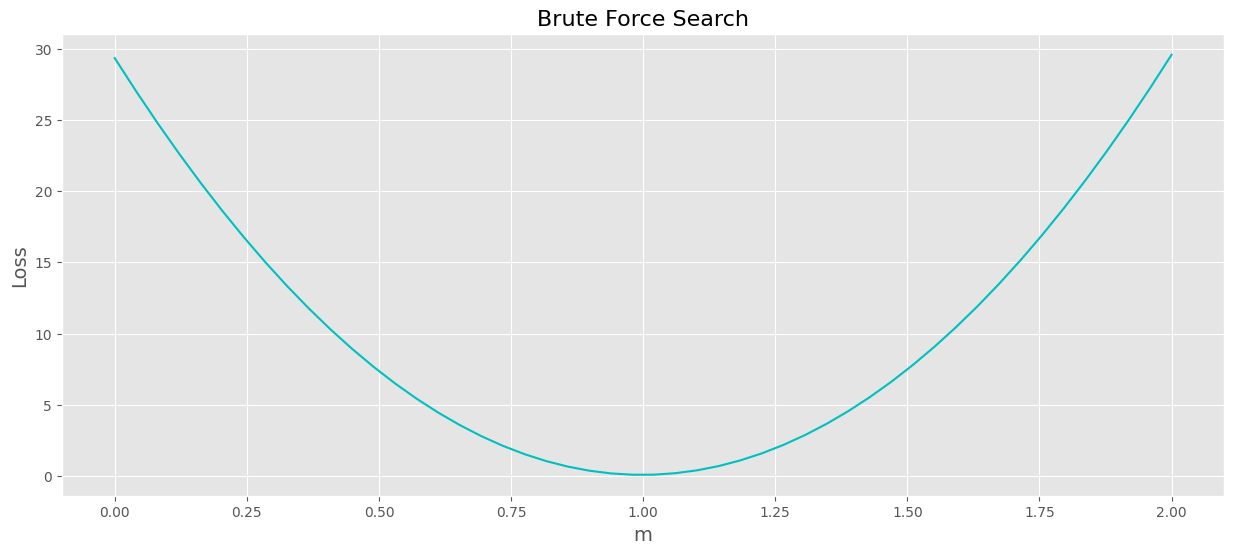

In [5]:
# Minimum value of m.
min_val = 0.0 

# Maximum value of m
max_val = 2.0 

# Number of steps between min and max values.
num_steps = 50

# Step size.
step_size = (max_val - min_val)/(num_steps - 1)

# Space for storing all values of m.
m = tf.Variable(tf.zeros(shape=[num_steps]))

# Space for storing loss corresponding to different values of m.
loss = tf.Variable(tf.zeros(shape=[num_steps]))

# Calculate loss for all possible m.
for i in range(0, num_steps):
    m[i].assign(min_val +  i * step_size)
    e = y - m[i] * x
    loss[i].assign(tf.reduce_sum(tf.multiply(e, e))/len(x))

# Find the index for lowest loss.
i = tf.argmin(loss)

# Save best slope.
m_best = m[i].numpy()

# Minimum loss.
print('Minimum Loss:  ', loss[i].numpy())

# Find the value of m corresponding to lowest loss.
print('Best parameter: ', m_best)

# Plot loss vs m.
plt.figure
plt.plot(m.numpy(), loss.numpy(), 'c-')
plt.xlabel('m')
plt.ylabel('Loss')
plt.title("Brute Force Search")
plt.show(block=block_plot)

#### <font style="color:rgb(50,120,230)">Compare the Model with the Data</font>

In [6]:
def plot_linear_model(x, y, m_best, xlim=(0, 10), ylim=(0, 10)):

    # Generate the line based on the optimal slope.
    xmin = tf.reduce_min(x)
    xmax = tf.reduce_max(x)
    ymin = tf.reduce_min(y)
    ymax = tf.reduce_max(y)
    
    xplot = np.linspace(xmin, xmax, 2)
    yplot = m_best * xplot

    # Plot the data and the model.
    plt.figure
    plt.xlim(xlim)
    plt.ylim(ylim) 
    plt.plot(xplot, yplot, 'c-')
    plt.scatter(x, y, color='blue', s=20)
    plt.xlabel('x')
    plt.ylabel('y')
    xc = .05 * (xmax - xmin)
    yc = .95 * (ymax - ymin)
    plt.text(xc, yc, 'Slope: ' + str(int(m_best*1000)/1000), fontsize=14)
    plt.show(block=block_plot)

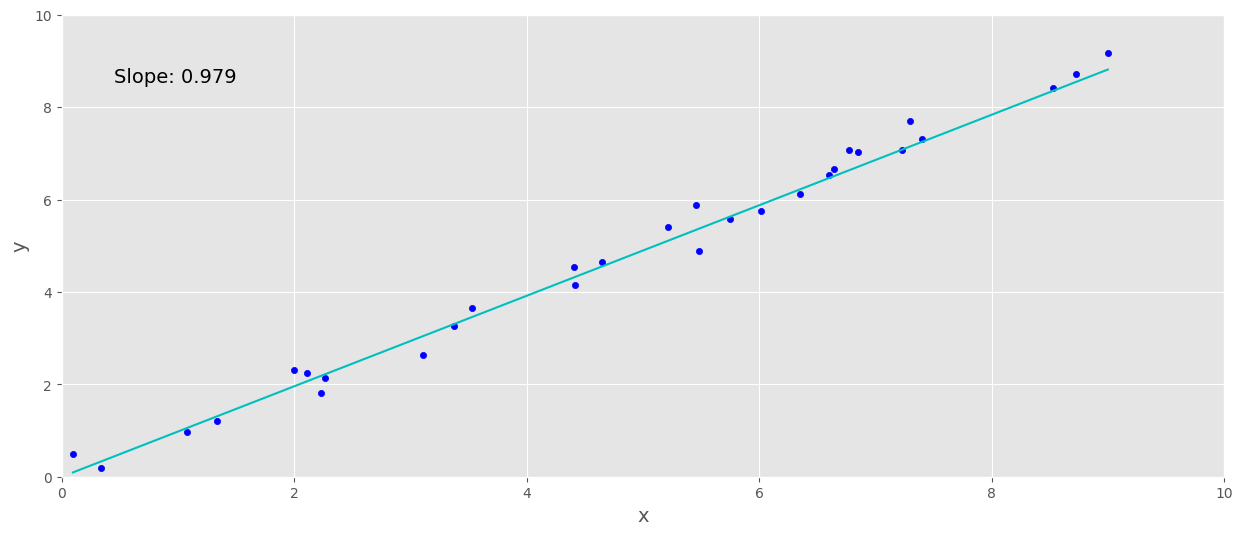

In [7]:
plot_linear_model(x, y, m_best)

### 4.2 Gradient Descent

Let's now discuss how gradient descent works. The 'loss' plot from the previous section shows that we can start from an initial guess of $m$, and follow the slope of the curve downward to reach the bottom of the curve. To automate this process, for a given value of $m$ we can compute the gradient of the loss function and use that value to inform us how to adjust $m$. If the gradient is positive, then we'll need to lower the value of $m$ to move closer to the minimum, and if the gradient is negative, we'll need to raise the value of $m$. This simple idea is called **Gradient Descent**. Assuming the loss function is convex and differentiable, we can calculate the gradient of the loss function with respect to $m$ at any point to accomplish this. 

Given the loss function:

$$
\begin{align}
l &= \frac{1}{n}\sum^n_{i=1}(y_i - m x_i)^2 \\
\end{align}
$$

We can compute the gradient of the loss with respect to $m$ using simple calculus:

$$
\begin{align}
\frac{\partial l}{\partial m}  &= \frac{-2}{n} \sum^n_{i=1} x_i(y_i - m x_i) \\
\end{align}
$$

Notice that we're computig the gradient for every point in the dataset, which is why this technique is also referred to as **Batch Gradient Descent** since we are processing a "batch" of data. Since a constant does not change the minimum of the loss function, we can eliminate the 2 from the above equation without changing the location of the minimum with respect to $m$.

$$
\begin{align}
\frac{\partial l}{\partial m}  &= \frac{1}{n} \sum^n_{i=1} x_i(y_i - m x_i) \\
\end{align}
$$

We can now use the gradient to develop and update rule for $m$. To follow the slope of the curve toward the minimum, we need to move $m$ in the direction of the negative gradient. However, we need to control the rate at which we move along the curve so that we do not overshoot the minimum. So we use a parameter, $\lambda$, called the **learning rate**. This is a parameter that requires tuning depending on the problem at hand. When working with larger, more complex problems, it can be tricky to set the learning rate appropriately. However, when we start using TensorFlow to solve optimization problems, we will have access to very robust optimizers to facilitate this process. Here, we are simply demonstrating the basic concepts.

$$
m_k = m_{k-1} - \lambda \frac{\partial l}{\partial m}
$$

Let's implement this in code to see that it works. Notice in the implementation below we are using all the data points to compute the gradient at each iteration.

In [8]:
# Parameter settings.
num_iter0 = 50 
lr0 = 0.005
# Initial guess for m.
m0 = 2  

max_loss = 30. # For plot scale.

Minimum loss:    0.065013476
Best parameter:  0.99831104


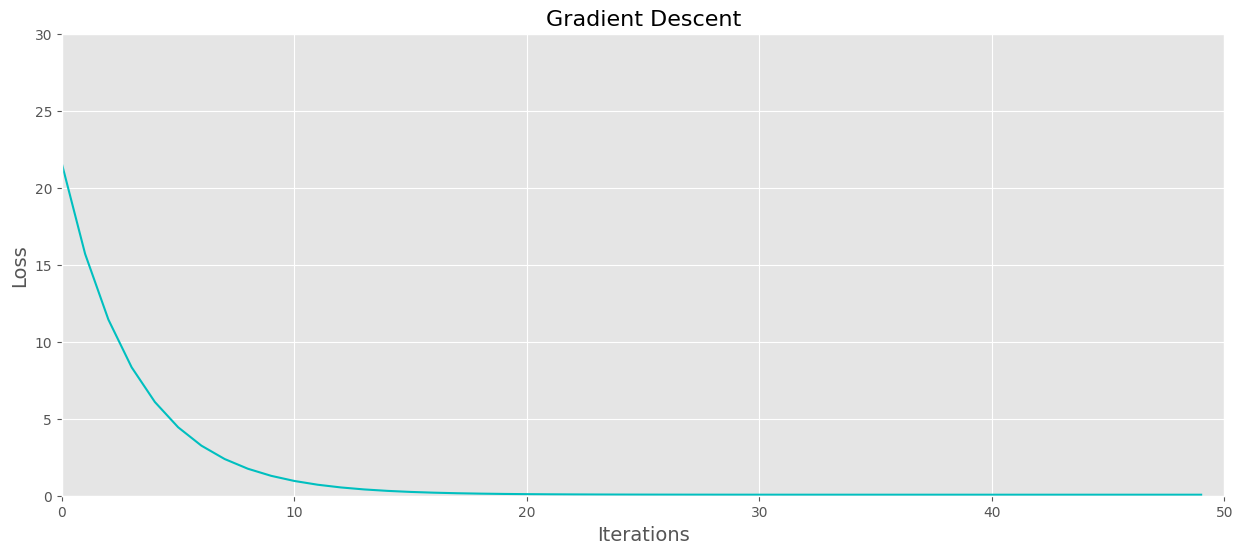

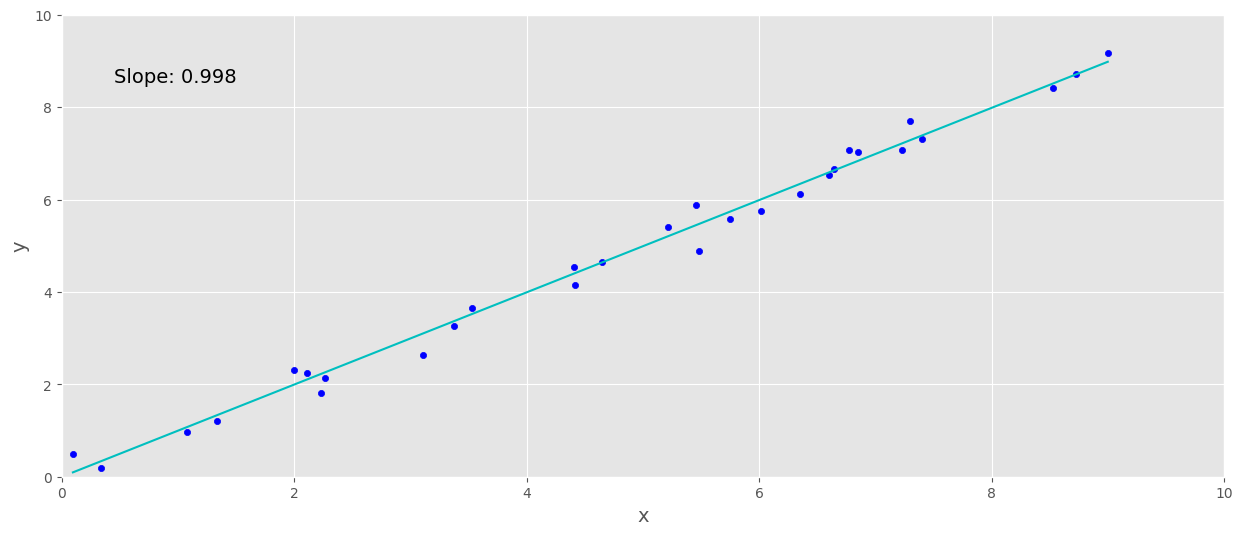

In [9]:
num_iter = num_iter0
lr = lr0
m = m0

# Loss for Gradient Descent.
loss_gd = tf.Variable(tf.zeros(shape=[num_iter]))
    
# Calculate the loss.
for i in range(0, num_iter):
    
    # Compute the gradient using the entire dataset.
    g = -tf.reduce_sum(x * (y - m * x))/len(x)
    
    # Update the parameter, m.
    m = m -  lr * g
    
    # Compute the loss for the updated value of m.
    e = y - m * x
    loss_gd[i].assign(tf.reduce_sum(tf.multiply(e,e))/len(x))
    
m_best =  m.numpy()

print('Minimum loss:   ', loss_gd[-1].numpy())
print('Best parameter: ', m_best)

# Plot loss vs m  
plt.figure
plt.plot(loss_gd.numpy(), 'c-')
plt.xlim(0, num_iter)
plt.ylim(0, max_loss)
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.title('Gradient Descent')
plt.show(block=block_plot)

plot_linear_model(x, y, m_best)

### 4.3 Stochastic Gradient Descent

In this example, we have only a handful of data points. In the real world, we can have millions of examples. Calculating the gradient based on all data points can be computationally expensive. Fortunately, it is not necessary to use all the data points for computing the gradient.

We can use a **single** randomly chosen data point to compute the gradient at each iteration. Even though the gradient at each step is not as accurate, the idea still works. In the example below, the convergence is much slower because the gradient is not as accurate. In the next section, we will extend this idea to use a small percentage of the data to better approximate the gradient yet limit the number of computations.

Minimum loss:    1.9848534
Best parameter:  [1.0042171]


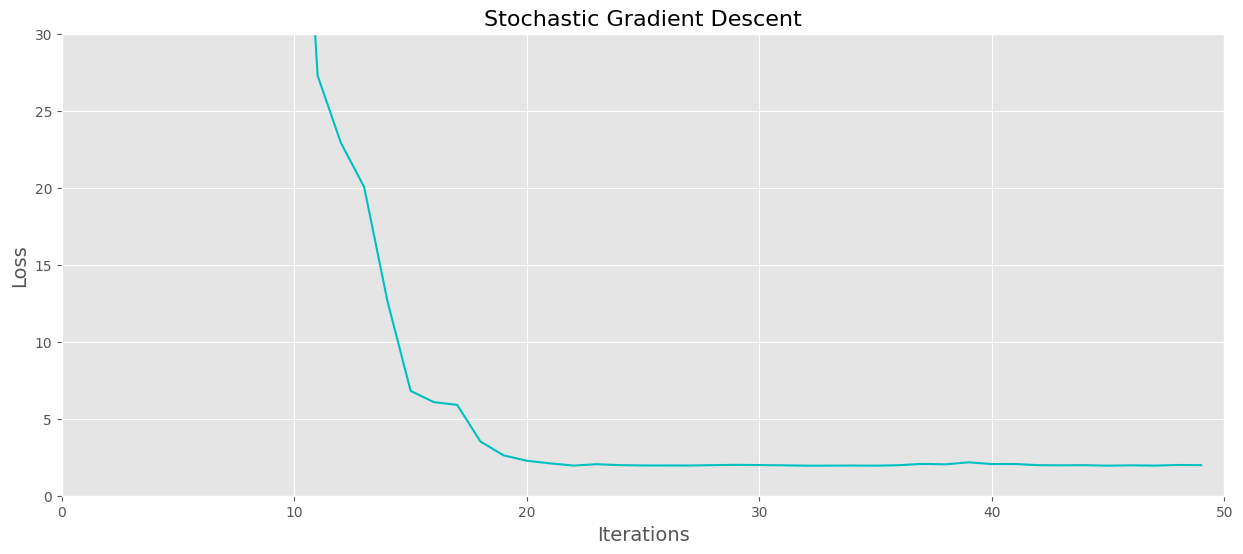

C:\Users\kshnt\AppData\Local\Temp\ipykernel_13636\718671393.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.text(xc, yc, 'Slope: ' + str(int(m_best*1000)/1000), fontsize=14)


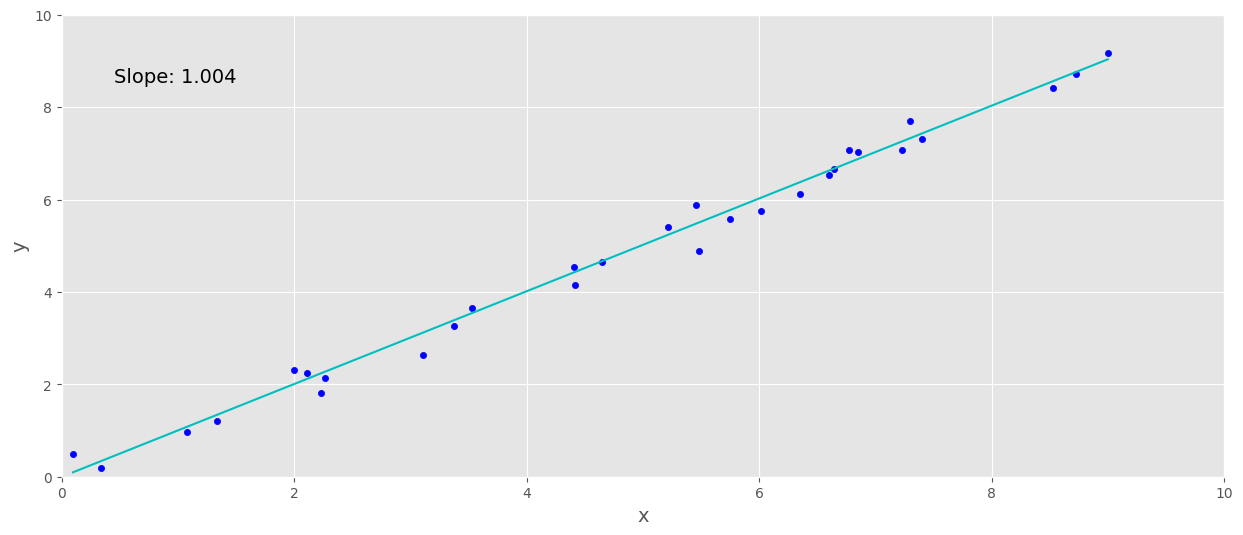

In [10]:
num_iter = num_iter0
lr = lr0
m = m0

# Loss for Stochastic Gradient Descent.
loss_sgd = tf.Variable(tf.zeros(num_iter))

for i in range(0, num_iter):

    # Randomly select a training data point.
    k = tf.random.uniform([1], minval=0, maxval=len(y), dtype=tf.dtypes.int32)

    # Calculate the gradient using a single data point.
    g = -tf.gather(x, k) * (tf.gather(y, k) - m * tf.gather(x, k))
    
    # Update the parameter, m.
    m = m - lr * g
    
    # Compute the loss for the updated value of m.
    e = y - m * x
    loss_sgd[i].assign(tf.reduce_sum(tf.multiply(e,e)))

m_best = m.numpy()

print('Minimum loss:   ', loss_sgd[-1].numpy())
print('Best parameter: ', m_best)

# Plot loss vs m  
plt.figure
plt.plot(loss_sgd.numpy(), 'c-')
plt.xlim(0, num_iter)
plt.ylim(0, max_loss)
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.title('Stochastic Gradient Descent');

plt.show(block=block_plot)
plot_linear_model(x, y, m_best)

### 4.4 Stochastic Gradient Descent with Mini-Batch

In the previous section, we saw that it is possible to calculate the gradient based on a single random data point chosen at each iteration. As long as we execute enough iterations, Stochastic Gradient Descent will still work. 

However, using more than one data point for the gradient calculation has two advantages:

1. Using multiple data points produces a more accurate estimate for the gradient.
2. GPUs are highly efficient at processing gradient computations.

So, we get better results and faster convergence if we use a small batch of data points, called a **mini-batch**, to compute the gradients. A "mini-batch" approach strikes a nice balance between using all the data points vs just a single data point.

Let's implement this in code and see for ourselves. 

Minimum loss:    0.19538029
Best parameter:  0.99596435


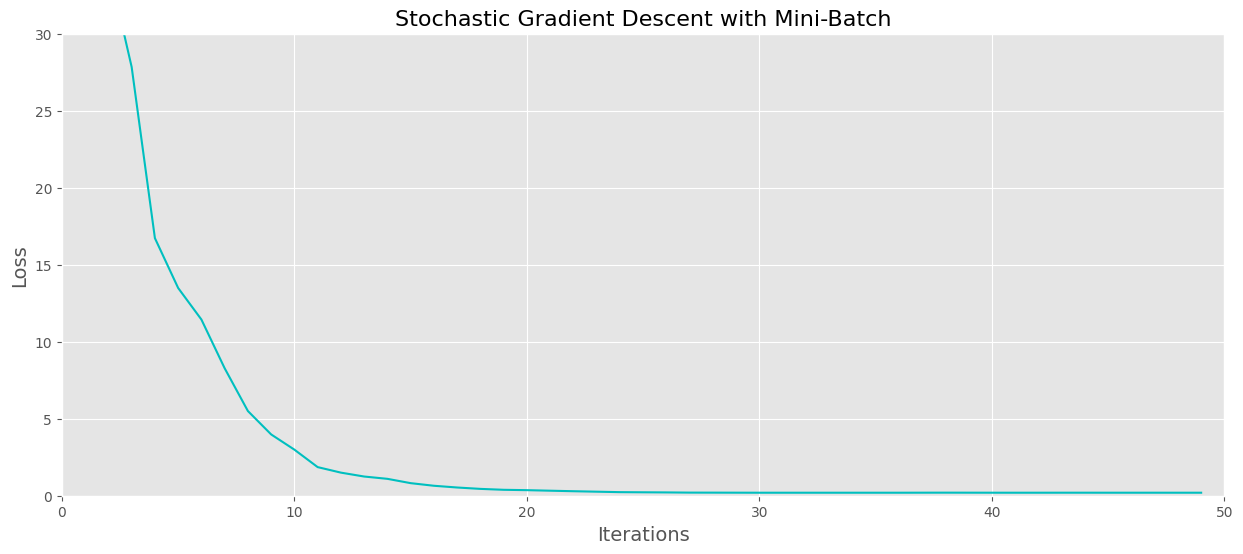

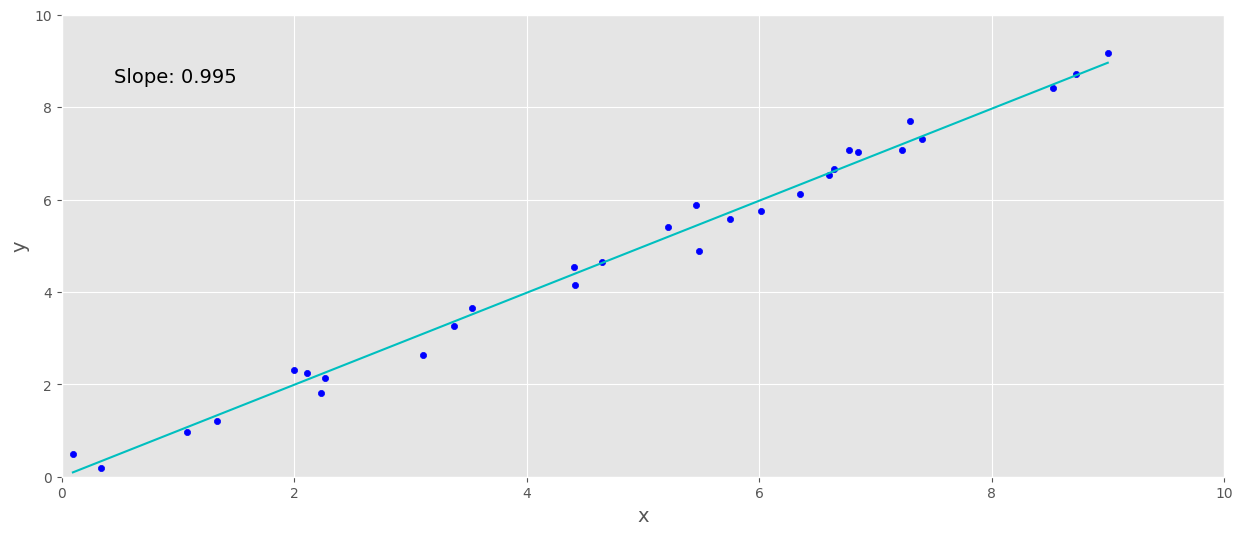

In [11]:
num_iter = num_iter0
lr = lr0
m = m0

batch_size = 10

# Loss for Gradient Descent with Mini-Batch.
loss_sgd_mb = tf.Variable(tf.zeros(num_iter))

for i in range(0, num_iter):

    # Randomly select a batch of data points.
    k = tf.random.uniform([batch_size], minval=0, maxval=len(y)-1, dtype=tf.dtypes.int32)
    
    # Calculate the gradient using a mini-batch.   
    g = -tf.reduce_sum(tf.gather(x, k) * (tf.gather(y, k) - m * tf.gather(x, k)))/batch_size
    
    # Update the parameter, m.
    m = m -  lr * g
    
    # Compute the loss for the updated value of m.
    e = y - m * x
    loss_sgd_mb[i].assign(tf.reduce_sum(tf.multiply(e,e))/batch_size)

m_best = m.numpy()
    
print('Minimum loss:   ', loss_sgd_mb[-1].numpy())
print('Best parameter: ', m.numpy())

# Plot loss vs m.
plt.figure
plt.plot(loss_sgd_mb.numpy(), 'c-')
plt.xlim(0, num_iter)
plt.ylim(0, max_loss); 
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.title('Stochastic Gradient Descent with Mini-Batch')
plt.show(block=block_plot)

plt.show(block=block_plot)
plot_linear_model(x, y, m_best)

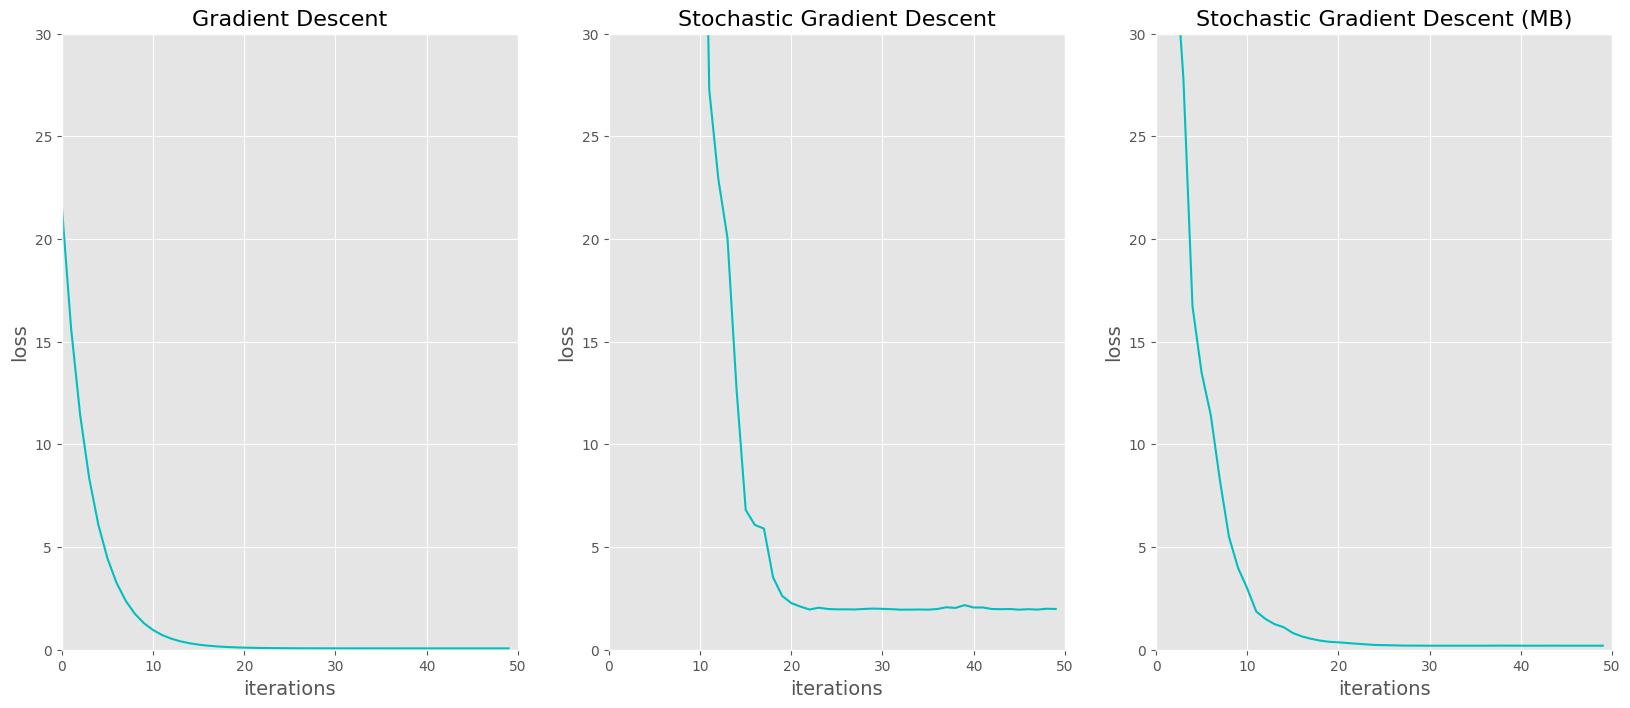

In [12]:
plt.figure(figsize = (20, 8))

plt.subplot(131); plt.plot(loss_gd.numpy(), 'c-'); plt.xlim(0, num_iter); plt.ylim(0, max_loss);     
plt.ylabel('loss'), plt.xlabel('iterations'); plt.title('Gradient Descent');

plt.subplot(132); plt.plot(loss_sgd.numpy(), 'c-'); plt.xlim(0, num_iter); plt.ylim(0, max_loss);    
plt.ylabel('loss'), plt.xlabel('iterations'); plt.title('Stochastic Gradient Descent');

plt.subplot(133); plt.plot(loss_sgd_mb.numpy(), 'c-'); plt.xlim(0, num_iter); plt.ylim(0, max_loss);    
plt.ylabel('loss'), plt.xlabel('iterations'); plt.title('Stochastic Gradient Descent (MB)');

## 5 Automatic Differentiation with `GradientTape`

Automatic differentiation is a powerful tool that is now available in modern day deep learning frameworks. Training neural networks requires a step called **back-propagation** that involves computing the gradient of the loss function with respect to the weights in the neural network. These computations can be tedious for even simple network architectures, but thanks to auto-differentiation in TensorFlow the process has been greatly simplified. As we will see in future videos, TensorFlow provides the built-in capability to train neural networks using the `compile()` and `fit()` methods which allow you to specify an optimizer. The optimizers in TensorFlow implement back-propagation using `GradientTape()`, so it is often not required to use `GradientTape()` explicitly. Still,  there are times when more advanced modelling is required in which you will need access to lower-level APIs in TensorFlow such as `GradientTape()`. In this section, we will introduce **`GradientTape`** and will demonstrate how we can use it to compute the gradient for the gradient descent algorithm. We will revisit this topic in more detail in future videos.

### 5.1 Using `GradientTape`

GradientTape is the API through which we can access the auto-differentiation capability in TensorFlow. You create a GradientTape context called a "tape" which is a Python scope that will automatically record every operation that involves a trainable variable. By default, all tensorflow variables created with `tf.Variable()` are trainable, but you can also use `tape.watch()` to further specify which tensors are recorded within the `GradientTape` context. After creating the `tape`, you can then use the tape to compute the gradient of a computation with respect to the trainable variables.

In [13]:
# Create a tensorflow variable.
x = tf.Variable(4.0)

# Create a GradientTape context.
with tf.GradientTape() as tape:
    # Create a new tensor y which equals the square of the x tensor.
    y = x * x
    
# Compute the derivative of y with respect to the input tensor x.
dy_dx = tape.gradient(y, x)
print('dy_dx: \n', dy_dx.numpy())

dy_dx: 
 8.0


In [14]:
# Create a tensorflow variables.
w1 = tf.Variable(5.0)
w2 = tf.Variable(3.0)

# Create a GradientTape context.
with tf.GradientTape(persistent=True) as tape:  
    z = 3 * w1 ** 2 + 2 * w1 * w2

# Compute the gradients.
dz_dw1 = tape.gradient(z, w1)
dz_dw2 = tape.gradient(z, w2)
del tape
print('dz_dw1: \n', dz_dw1.numpy())
print('dz_dw2: \n', dz_dw2.numpy())

dz_dw1: 
 36.0
dz_dw2: 
 10.0


### 5.2 Gradient Descent with `GradientTape`

Minimum loss:    0.06500983
Best parameter:  0.99795854


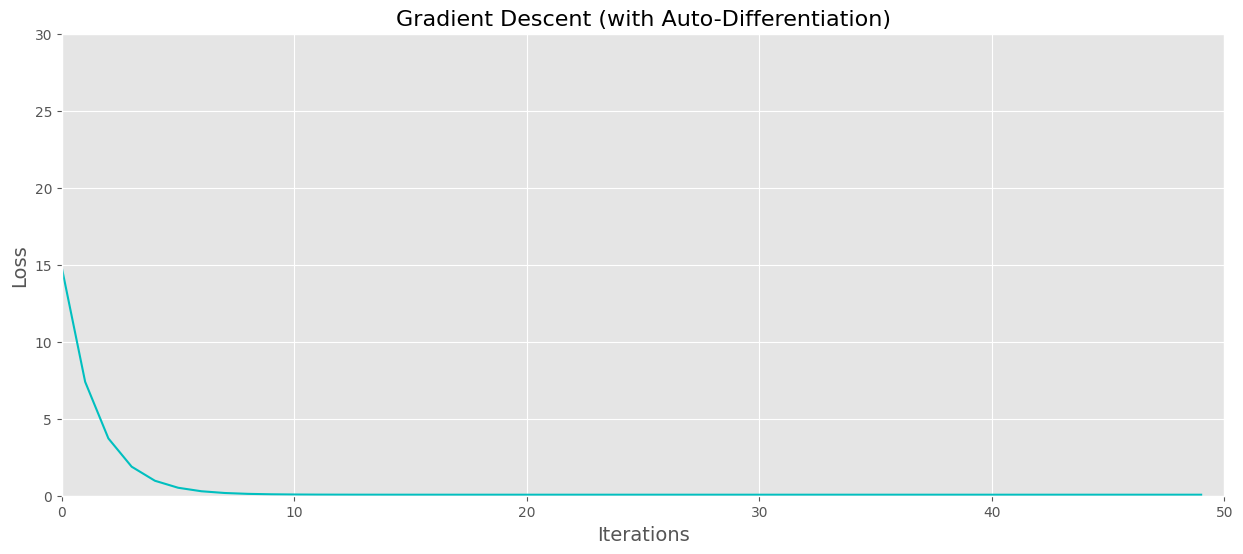

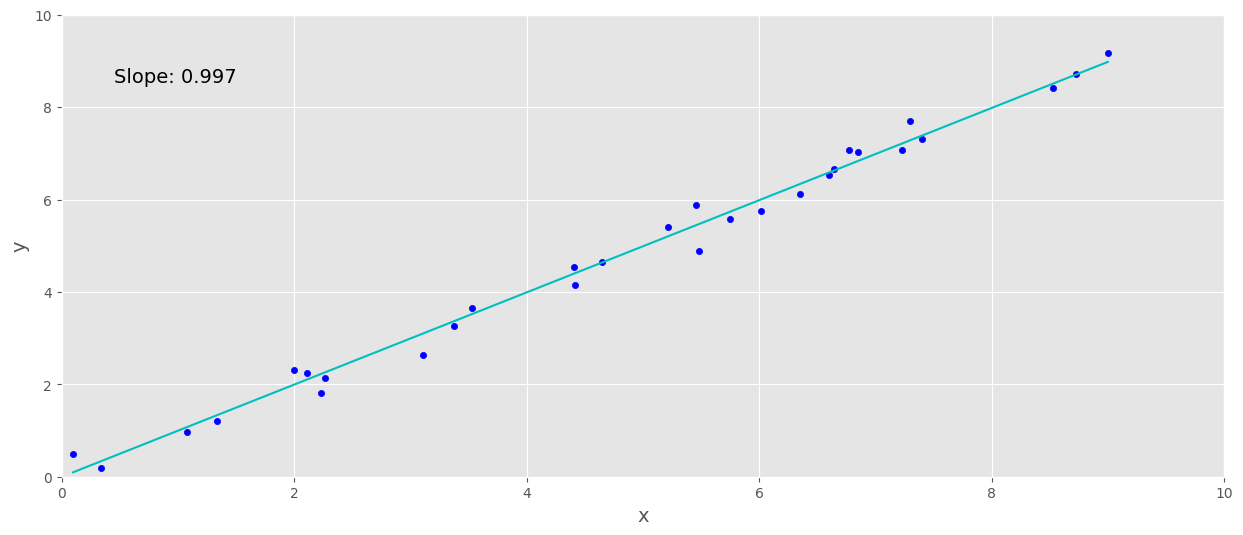

In [15]:
num_iter = num_iter0
lr = lr0
m  = tf.Variable(2.0)  # Initial guess for m.

x, y = create_data()

loss_gd = tf.Variable(tf.zeros(shape=[num_iter]))
    
for i in range(0, num_iter):
    
    # Set up a gradient tape context to monitor operations on variables.
    with tf.GradientTape() as tape:
        # MSE loss.
        loss = tf.pow((y - m * x), 2)/len(x)
        
    # Compute the gradient of the loss with respect to m automatically.
    dl_dm = tape.gradient(loss, m)
    
    # Update the paramter m.
    m.assign_sub(lr * dl_dm)
    
    # Compute the loss for the updated value of m.
    e = y - m * x
    loss_gd[i].assign(tf.reduce_sum(tf.multiply(e,e))/len(x))
    
m_best =  m.numpy()
print('Minimum loss:   ', loss_gd[-1].numpy())
print('Best parameter: ', m_best)

# Plot loss vs m. 
plt.figure
plt.plot(loss_gd.numpy(), 'c-')
plt.xlim(0, num_iter)
plt.ylim(0, max_loss)
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.title('Gradient Descent (with Auto-Differentiation)')
plt.show(block=block_plot)

plot_linear_model(x, y, m_best)

## Exercise
Here are a few things that you may try with the above code and have fun!

1. Experiment with the learning rate (make it higher and lower).
2. Experiment with a larger dataset and the size of the mini-batch
3. Try implementing a linear model of the form `y = mx + b`